# Analítica Avanzada de datos con PySpark

En este notebook haremos recopilación de las funciones más habituales que se utilizan en el análisis y pre-procesamiento de los datos

In [1]:
import findspark
findspark.init()

import pandas as pd
import pyspark

In [3]:
from pyspark.sql import functions as f
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### Inicio de la sesión de Spark

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate() #si existe una sesion existente la usa y sino la crea

## 1. Lectura de los datos

In [6]:
# Before changing schema importamos los datos (csv,datos, tablas relacionales)
b_data = spark.read.csv(
    'data/stocks_price_final.csv',
    sep = ',',
    header = True, #primera fila con encabezado
    )

b_data.printSchema() #esquema de datos obtenidos


#datos de las acciones de estados unidos enero 2019-junio 2020
#queremos entrenar un modelo de regresión para predecir el precio futuro de las acciones de estados unidos
#no podemos de primeras entrenar el modelo sino que debemos emplear analitica avanzada.

root
 |-- _c0: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



#### Cambiar la estructura de datos

In [8]:
from pyspark.sql.types import *
#algunas veces el tipo de datos inferido por pyspark es incorrecto y debemos modificarlo manualmente
data_schema = [
               StructField('_c0', IntegerType(), True), # nombre_variable, tipo_dato, nullable- Si= True, No=False
               StructField('symbol', StringType(), True),  #norml. será False si los datos son de tipo #Id 
               StructField('data', DateType(), True),
               StructField('open', DoubleType(), True),
               StructField('high', DoubleType(), True),
               StructField('low', DoubleType(), True),
               StructField('close', DoubleType(), True),
               StructField('volume', IntegerType(), True),
               StructField('adjusted', DoubleType(), True),
               StructField('market.cap', StringType(), True),
               StructField('sector', StringType(), True),
               StructField('industry', StringType(), True),
               StructField('exchange', StringType(), True),
            ]

final_struc = StructType(fields=data_schema)

In [9]:
data = spark.read.csv(
    'data/stocks_price_final.csv',
    sep = ',',
    header = True,
    schema = final_struc #le pasamos el esquema que acabamos de crear
    )

In [10]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- data: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- adjusted: double (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [11]:
data.show(5) #mostrar las primeras 5 filas

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      data|     open|     high|      low|    close| volume| adjusted|market.cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|  1|   TXG|2019-09-12|     54.0|     58.0|     51.0|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  3|   TXG|2019-09-16|52.450001|     56.0|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  5|   TXG|2019-09-18|56.849998|    62.2

In [12]:
data = data.withColumnRenamed('market.cap', 'market_cap') #renombramos las variables

El punto puede generar errores ya que lo que hay antes del punto suele indicar el dataframe asique cuando nos encontramos con variables de este estilo lo mejor es cambiar el punto con barra baja.

## 2. Inspeccionar los datos
* schema()
* dtypes
* head()
* show()
* first()
* take(n)
* describe()
* columns
* count()
* distinct()
* printSchema()

In [13]:
# prints Schema of thte data
data.schema 

StructType(List(StructField(_c0,IntegerType,true),StructField(symbol,StringType,true),StructField(data,DateType,true),StructField(open,DoubleType,true),StructField(high,DoubleType,true),StructField(low,DoubleType,true),StructField(close,DoubleType,true),StructField(volume,IntegerType,true),StructField(adjusted,DoubleType,true),StructField(market_cap,StringType,true),StructField(sector,StringType,true),StructField(industry,StringType,true),StructField(exchange,StringType,true)))

In [14]:
data.dtypes #devuelve una lista de tupla con nombre de las columnas y el tipo de dato.

[('_c0', 'int'),
 ('symbol', 'string'),
 ('data', 'date'),
 ('open', 'double'),
 ('high', 'double'),
 ('low', 'double'),
 ('close', 'double'),
 ('volume', 'int'),
 ('adjusted', 'double'),
 ('market_cap', 'string'),
 ('sector', 'string'),
 ('industry', 'string'),
 ('exchange', 'string')]

In [15]:
data.head(3)

[Row(_c0=1, symbol='TXG', data=datetime.date(2019, 9, 12), open=54.0, high=58.0, low=51.0, close=52.75, volume=7326300, adjusted=52.75, market_cap='$9.31B', sector='Capital Goods', industry='Biotechnology: Laboratory Analytical Instruments', exchange='NASDAQ'),
 Row(_c0=2, symbol='TXG', data=datetime.date(2019, 9, 13), open=52.75, high=54.355, low=49.150002, close=52.27, volume=1025200, adjusted=52.27, market_cap='$9.31B', sector='Capital Goods', industry='Biotechnology: Laboratory Analytical Instruments', exchange='NASDAQ'),
 Row(_c0=3, symbol='TXG', data=datetime.date(2019, 9, 16), open=52.450001, high=56.0, low=52.009998, close=55.200001, volume=269900, adjusted=55.200001, market_cap='$9.31B', sector='Capital Goods', industry='Biotechnology: Laboratory Analytical Instruments', exchange='NASDAQ')]

In [15]:
data.show(5)

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      data|     open|     high|      low|    close| volume| adjusted|market_cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|  1|   TXG|2019-09-12|     54.0|     58.0|     51.0|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  3|   TXG|2019-09-16|52.450001|     56.0|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  5|   TXG|2019-09-18|56.849998|    62.2

In [16]:
data.first() #devuelve la primera fila de datos

Row(_c0=1, symbol='TXG', data=datetime.date(2019, 9, 12), open=54.0, high=58.0, low=51.0, close=52.75, volume=7326300, adjusted=52.75, market_cap='$9.31B', sector='Capital Goods', industry='Biotechnology: Laboratory Analytical Instruments', exchange='NASDAQ')

In [17]:
data.describe().show() #calcula las estadisitcas

+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------------+--------------------+--------+
|summary|              _c0| symbol|              open|              high|               low|             close|            volume|          adjusted|market_cap|          sector|            industry|exchange|
+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------------+--------------------+--------+
|  count|          1729034|1729034|           1726301|           1726301|           1726301|           1726301|           1725207|           1726301|   1729034|         1729034|             1729034| 1729034|
|   mean|         864517.5|   null|15070.071703341047|15555.067268137087|14557.808227578987| 15032.71485433071|1397692.1627885813|14926.109688795501|      null|        

In [18]:
data.columns #lista con nombre de la columna de los datos

['_c0',
 'symbol',
 'data',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'adjusted',
 'market_cap',
 'sector',
 'industry',
 'exchange']

In [19]:
data.count() #numero de filas en los datos

1729034

In [20]:
data.distinct().count() 

1729034

In [21]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- data: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- adjusted: double (nullable = true)
 |-- market_cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



## 3. Transformación de columnas
* Añadir columnas
* Modificar columnas existentes
* Eliminar columnas

In [17]:
data = data.withColumn('date', data.data)

data.show(5)

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+----------+
|_c0|symbol|      data|     open|     high|      low|    close| volume| adjusted|market_cap|       sector|            industry|exchange|      date|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+----------+
|  1|   TXG|2019-09-12|     54.0|     58.0|     51.0|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2019-09-12|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2019-09-13|
|  3|   TXG|2019-09-16|52.450001|     56.0|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2019-09-16|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotec

In [23]:
data = data.withColumnRenamed('date', 'data_changed')

data.show(5)

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+------------+
|_c0|symbol|      data|     open|     high|      low|    close| volume| adjusted|market_cap|       sector|            industry|exchange|data_changed|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+------------+
|  1|   TXG|2019-09-12|     54.0|     58.0|     51.0|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|  2019-09-12|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|  2019-09-13|
|  3|   TXG|2019-09-16|52.450001|     56.0|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|  2019-09-16|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital 

In [24]:
data = data.drop('data_changed')

data.show(5)

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      data|     open|     high|      low|    close| volume| adjusted|market_cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+
|  1|   TXG|2019-09-12|     54.0|     58.0|     51.0|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  3|   TXG|2019-09-16|52.450001|     56.0|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  5|   TXG|2019-09-18|56.849998|    62.2

In [24]:
from pyspark.ml.feature import Imputer

df = spark.createDataFrame([
    (1.0, float("nan")),
    (2.0, float("nan")),
    (float("nan"), 3.0),
    (4.0, 4.0),
    (5.0, 5.0)
], ["a", "b"])

In [26]:
imputer = Imputer(inputCols=["a", "b"], outputCols=["out_a", "out_b"])
model = imputer.fit(df)

model.transform(df).show()


+---+---+-----+-----+
|  a|  b|out_a|out_b|
+---+---+-----+-----+
|1.0|NaN|  1.0|  4.0|
|2.0|NaN|  2.0|  4.0|
|NaN|3.0|  3.0|  3.0|
|4.0|4.0|  4.0|  4.0|
|5.0|5.0|  5.0|  5.0|
+---+---+-----+-----+



## 4. Imputando datos faltantes

In [22]:
# Remove Rows with Missing Values
data.na.drop() #identificamos los valores faltante y los eliminamos

# Replacing Missing Values with Mean
data.na.fill(data.select(f.mean(data['open'])).collect()[0][0])

# Replacing Missing Values with new values
data.na.replace(old_value, new_vallue)

NameError: name 'old_value' is not defined

## 5. Selección de datos con PySpark SQL
* Select
* Filter
* Between
* When
* Like
* GroupBy
* Aggregations

### Select

In [25]:
data.select(['open', 'high', 'low', 'close', 'volume', 'adjusted']).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              open|              high|               low|             close|            volume|          adjusted|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|           1726301|           1726301|           1726301|           1726301|           1725207|           1726301|
|   mean|15070.071703341047|15555.067268137087|14557.808227578987| 15032.71485433071|1397692.1627885813|14926.109688795501|
| stddev|1111821.8002863121|1148247.1953514938| 1072968.155843422|1109755.9294000654|5187522.9081691075|1101877.6328940047|
|    min|             0.072|             0.078|             0.052|             0.071|                 0|         -1.230099|
|    max|      1.60168176E8|      1.61601456E8|      1.55151728E8|      1.58376592E8|         656504200|      1.57249392E8|
+-------

### Filter

In [45]:
from pyspark.sql.functions import col, lit

data.filter( (col('data') >= lit('2020-01-01')) 
            & (col('data') <= lit('2020-01-31')) ).show(5)

+---+------+----------+---------+---------+---------+---------+------+---------+----------+-------------+--------------------+--------+
|_c0|symbol|      data|     open|     high|      low|    close|volume| adjusted|market_cap|       sector|            industry|exchange|
+---+------+----------+---------+---------+---------+---------+------+---------+----------+-------------+--------------------+--------+
| 78|   TXG|2020-01-02|76.910004|77.989998|71.480003|72.830002|220200|72.830002|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 79|   TXG|2020-01-03|71.519997|76.188004|70.580002|75.559998|288300|75.559998|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 80|   TXG|2020-01-06|75.269997|77.349998|73.559998|75.550003|220600|75.550003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 81|   TXG|2020-01-07|     76.0|77.279999|    75.32|75.980003|182400|75.980003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
| 82|   TXG|2020-01-08|76.089996|76.949997|72.73

### Between

In [44]:
data.filter(data.adjusted.between(100.0, 500.0)).show(5)

+----+------+----------+----------+----------+----------+----------+------+----------+----------+-------------+--------------------+--------+
| _c0|symbol|      data|      open|      high|       low|     close|volume|  adjusted|market_cap|       sector|            industry|exchange|
+----+------+----------+----------+----------+----------+----------+------+----------+----------+-------------+--------------------+--------+
|  93|   TXG|2020-01-24| 95.459999|     101.0| 94.157997|100.790001|328100|100.790001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  94|   TXG|2020-01-27| 99.760002|104.892998| 97.019997|103.209999|334900|103.209999|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|  95|   TXG|2020-01-28|104.620003|108.269997|103.297997|106.620003|245400|106.620003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|
|6893|  ABMD|2019-01-02|315.940002|320.709991|307.029999|309.959991|590000|309.959991|   $13.39B|  Health Care|Medical/Dental In...|  NASDAQ|
|6894|

### When

In [46]:
data.select('open', 'close', 
            f.when(data.adjusted >= 200.0, 1).otherwise(0)).show(5)

+---------+---------+-----------------------------------------------+
|     open|    close|CASE WHEN (adjusted >= 200.0) THEN 1 ELSE 0 END|
+---------+---------+-----------------------------------------------+
|     54.0|    52.75|                                              0|
|    52.75|    52.27|                                              0|
|52.450001|55.200001|                                              0|
|56.209999|56.779999|                                              0|
|56.849998|     62.0|                                              0|
+---------+---------+-----------------------------------------------+
only showing top 5 rows



### Like

In [47]:
data.select('sector', 
            data.sector.rlike('^[B,C]').alias('Sector Starting with B or C')
            ).distinct().show()

+--------------------+---------------------------+
|              sector|Sector Starting with B or C|
+--------------------+---------------------------+
|         Health Care|                      false|
|       Capital Goods|                       true|
|Consumer Non-Dura...|                       true|
|    Public Utilities|                      false|
|   Consumer Durables|                       true|
|             Finance|                      false|
|      Transportation|                      false|
|       Miscellaneous|                      false|
|   Consumer Services|                       true|
|              Energy|                      false|
|    Basic Industries|                       true|
|          Technology|                      false|
+--------------------+---------------------------+



### GroupBy

In [48]:
data.select(['industry', 'open', 'close', 'adjusted']).groupBy('industry').mean().show()

+--------------------+------------------+------------------+------------------+
|            industry|         avg(open)|        avg(close)|     avg(adjusted)|
+--------------------+------------------+------------------+------------------+
|Finance/Investors...| 5.134401785714288| 5.136630739795919| 4.991354066964286|
|       Miscellaneous| 16.38588266938775|16.359879090306126|16.148959322959186|
|Investment Banker...|58.950580945750225| 58.98308596082619| 58.15783725890314|
|   Food Distributors| 43.27450856935453| 43.27317810574849| 42.91047608357857|
|Miscellaneous man...|15.660586409948984|15.650934860969391|15.369818847193876|
|    Ophthalmic Goods|108.50137892138575| 108.5404598760826|108.52516121052633|
|        Broadcasting| 24.91678746482517| 24.91738845539515|24.699102029625312|
|Agricultural Chem...|22.046413928996596| 22.04205107631803|21.635093418154764|
|Biotechnology: Bi...|24.808083192324226| 24.80358714993552| 24.74507997827328|
|Other Specialty S...| 84.80718810562868

### Agregation

In [38]:
from pyspark.sql.functions import col, min, max, avg, lit

data.groupBy("sector") \
    .agg(min("data").alias("From"), 
         max("data").alias("To"), 
         
         min("open").alias("Minimum Opening"),
         max("open").alias("Maximum Opening"), 
         avg("open").alias("Average Opening"), 

         min("close").alias("Minimum Closing"), 
         max("close").alias("Maximum Closing"), 
         avg("close").alias("Average Closing"), 

         min("adjusted").alias("Minimum Adjusted Closing"), 
         max("adjusted").alias("Maximum Adjusted Closing"), 
         avg("adjusted").alias("Average Adjusted Closing"), 

      ).show(truncate=False)

+---------------------+----------+----------+---------------+---------------+------------------+---------------+---------------+------------------+------------------------+------------------------+------------------------+
|sector               |From      |To        |Minimum Opening|Maximum Opening|Average Opening   |Minimum Closing|Maximum Closing|Average Closing   |Minimum Adjusted Closing|Maximum Adjusted Closing|Average Adjusted Closing|
+---------------------+----------+----------+---------------+---------------+------------------+---------------+---------------+------------------+------------------------+------------------------+------------------------+
|Miscellaneous        |2019-01-02|2020-07-22|0.147          |1059.98999     |52.038394969006596|0.1361         |1035.829956    |52.063628549509616|0.1361                  |1035.829956             |51.80973033632299       |
|Health Care          |2019-01-02|2020-07-22|0.072          |186000.0       |119.96763306523255|0.071       

Obtenga los datos mínimos, máximos y promedio de los sectores de **enero de 2019** a **enero de 2020**

In [39]:
data.filter( (col('data') >= lit('2019-01-02')) & (col('data') <= lit('2020-01-31')) )\
    .groupBy("sector") \
    .agg(min("data").alias("From"), 
         max("data").alias("To"), 
         
         min("open").alias("Minimum Opening"),
         max("open").alias("Maximum Opening"), 
         avg("open").alias("Average Opening"), 

         min("close").alias("Minimum Closing"), 
         max("close").alias("Maximum Closing"), 
         avg("close").alias("Average Closing"), 

         min("adjusted").alias("Minimum Adjusted Closing"), 
         max("adjusted").alias("Maximum Adjusted Closing"), 
         avg("adjusted").alias("Average Adjusted Closing"), 

      ).show(truncate=False)

+---------------------+----------+----------+---------------+---------------+------------------+---------------+---------------+------------------+------------------------+------------------------+------------------------+
|sector               |From      |To        |Minimum Opening|Maximum Opening|Average Opening   |Minimum Closing|Maximum Closing|Average Closing   |Minimum Adjusted Closing|Maximum Adjusted Closing|Average Adjusted Closing|
+---------------------+----------+----------+---------------+---------------+------------------+---------------+---------------+------------------+------------------------+------------------------+------------------------+
|Miscellaneous        |2019-01-02|2020-01-31|0.16           |690.0          |51.51619596530091 |0.16           |691.099976     |51.54953412269035 |0.16                    |691.099976              |51.210507338518944      |
|Health Care          |2019-01-02|2020-01-31|0.072          |186000.0       |146.7756197567625 |0.071       

In [ ]:
spark.sql("select * from temp_table where adjusted = 500").show()

## 6. Visualización de datos

In [28]:
sec_df =  data.select(['sector', 'open', 'close', 'adjusted']).groupBy('sector').mean().toPandas()

In [39]:
sec_df.columns.tolist()

['sector', 'avg(open)', 'avg(close)', 'avg(adjusted)']

<AxesSubplot: xlabel='sector'>

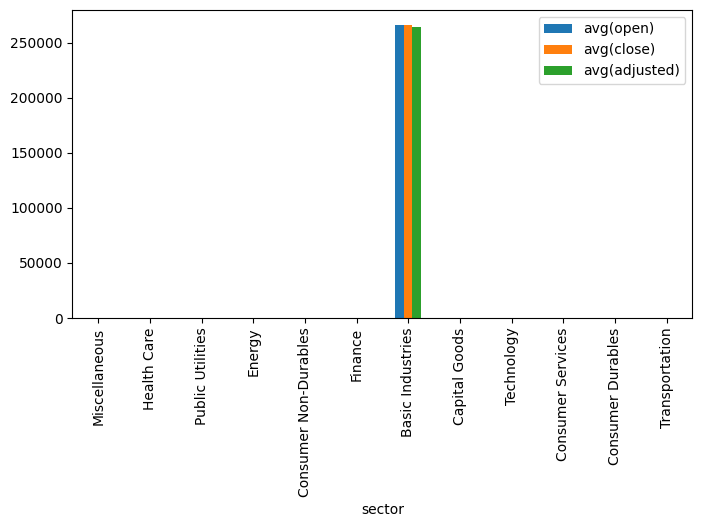

In [43]:
sec_df.plot(kind = 'bar', x='sector', y = sec_df.columns.tolist()[1:], figsize=(8, 4)) #grafico barras
# en x : diferentes sectores, en y:

In [49]:
ind = list(range(12))
ind.pop(6)
print(ind)

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]


### Elimine algunas de las **industrias básicas** y véala de nuevo 

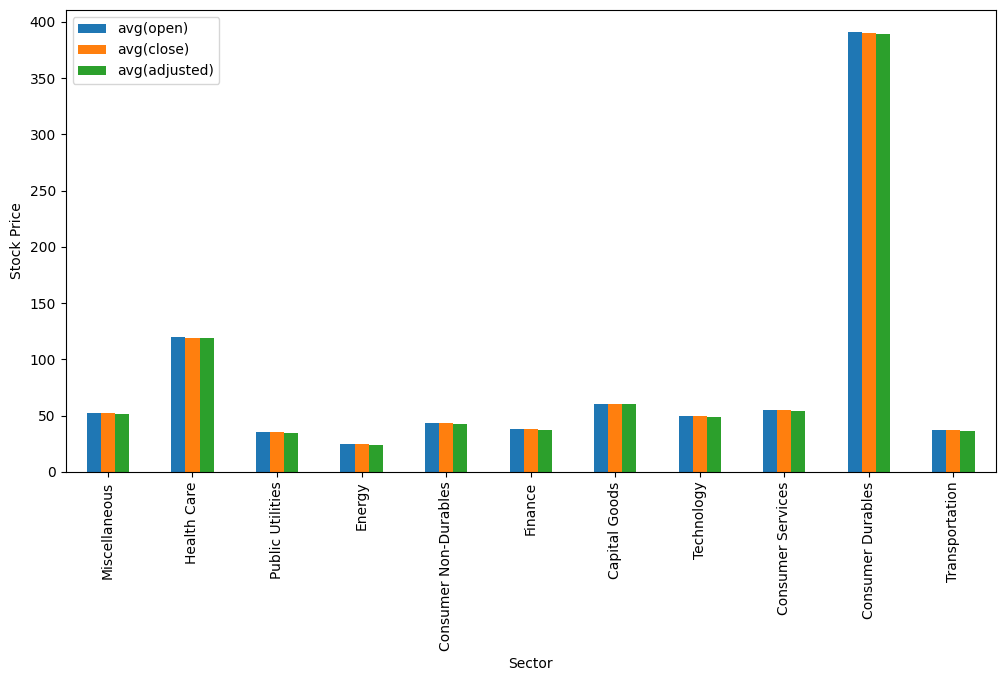

In [31]:
ind = list(range(12)) #lista [0,1.....11]
ind.pop(6) #elimina el valor 6 de la lista
sec_df.iloc[ind ,:].plot(kind = 'bar', x='sector', y = sec_df.columns.tolist()[1:], figsize=(12, 6), 
                         ylabel = 'Stock Price', xlabel = 'Sector')
plt.show()

In [40]:
industries_x = data.select(['industry', 'open', 'close', 'adjusted']).groupBy('industry').mean().toPandas()

industries_x.head()

,industry,avg(open),avg(close),avg(adjusted)
0,Finance/Investors Services,5.134402,5.136631,4.991354
1,Miscellaneous,16.385883,16.359879,16.148959
2,Investment Bankers/Brokers/Service,58.950581,58.983086,58.157837
3,Food Distributors,43.274509,43.273178,42.910476
4,Miscellaneous manufacturing industries,15.660586,15.650935,15.369819


<AxesSubplot: ylabel='industry'>

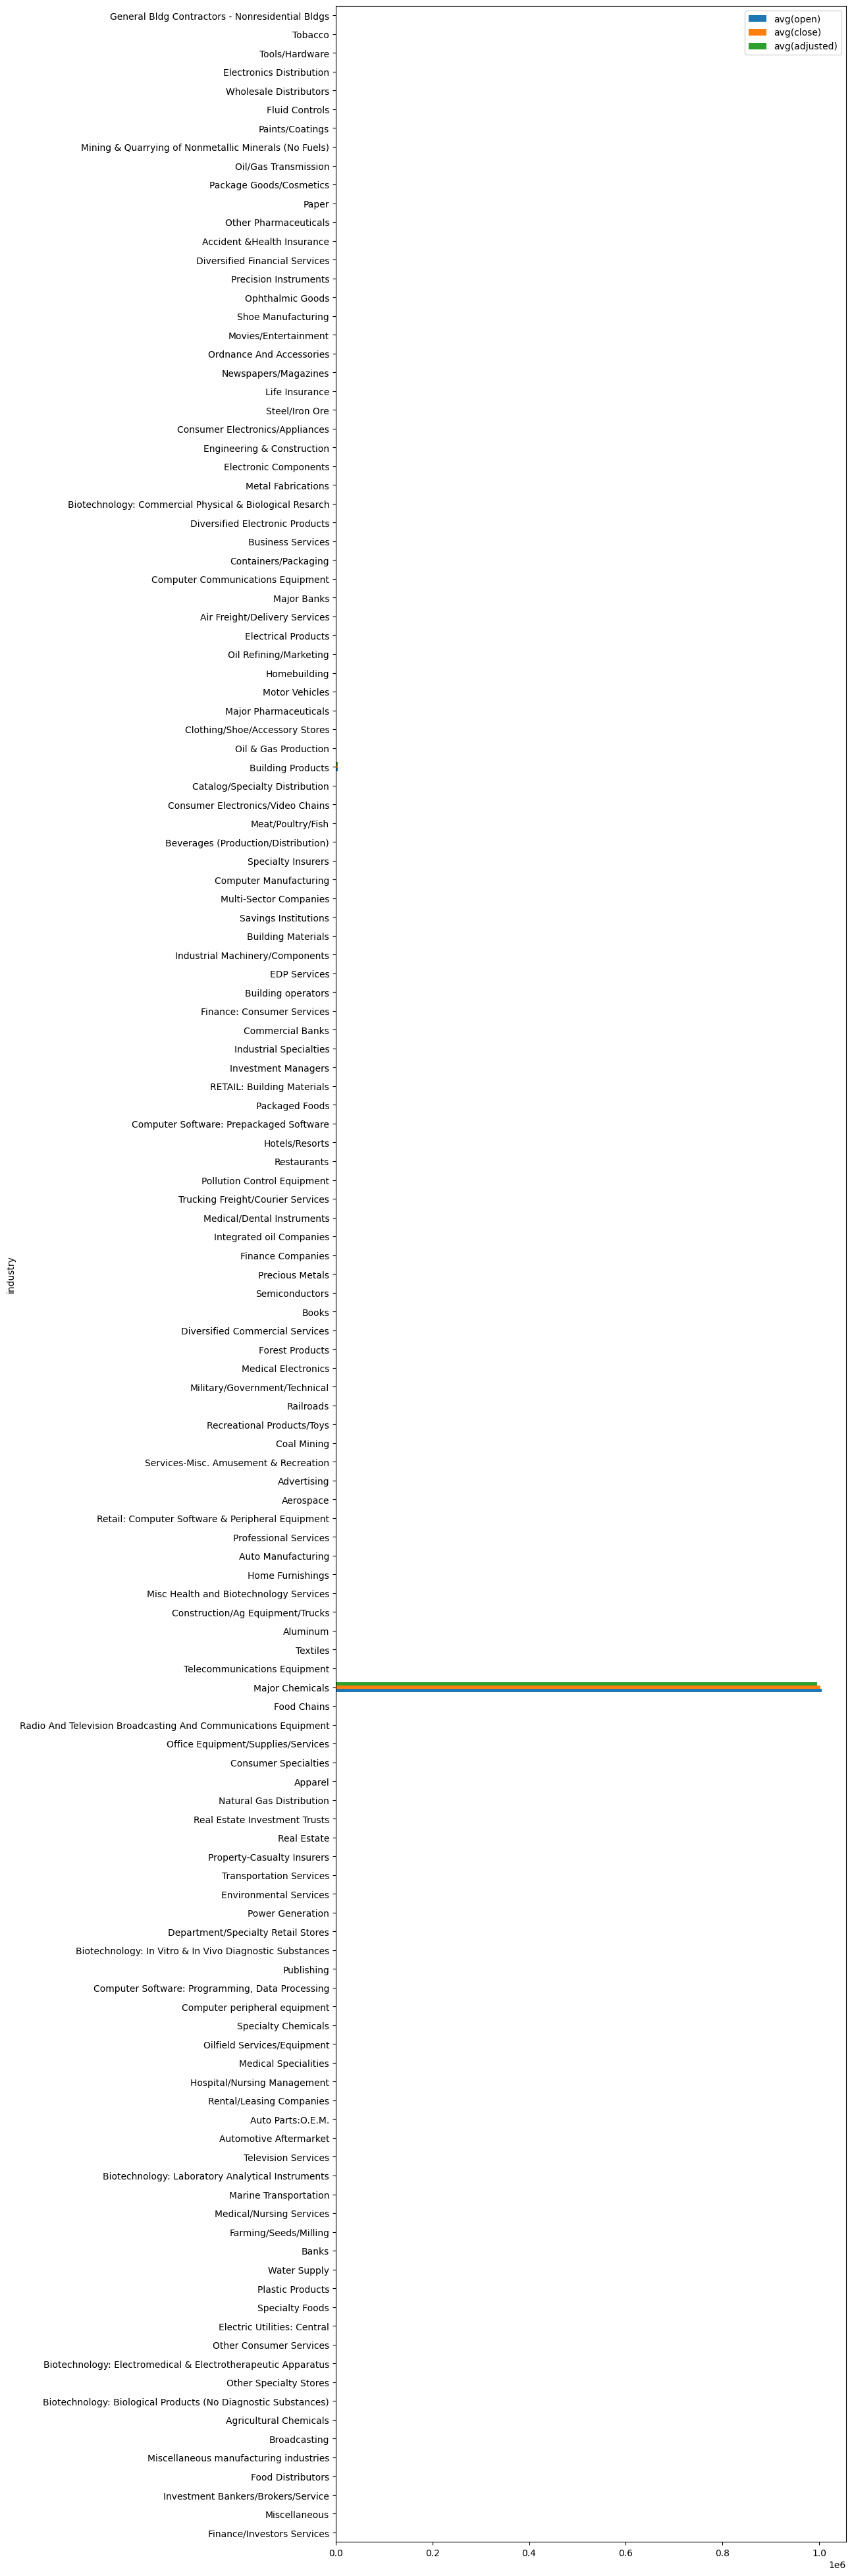

In [41]:
industries_x.plot(kind = 'barh', x='industry', 
                  y = industries_x.columns.tolist()[1:], figsize=(10, 50))

Elimine **sustancias químicas importantes** y **productos de construcción** para ver los datos restantes con claridad

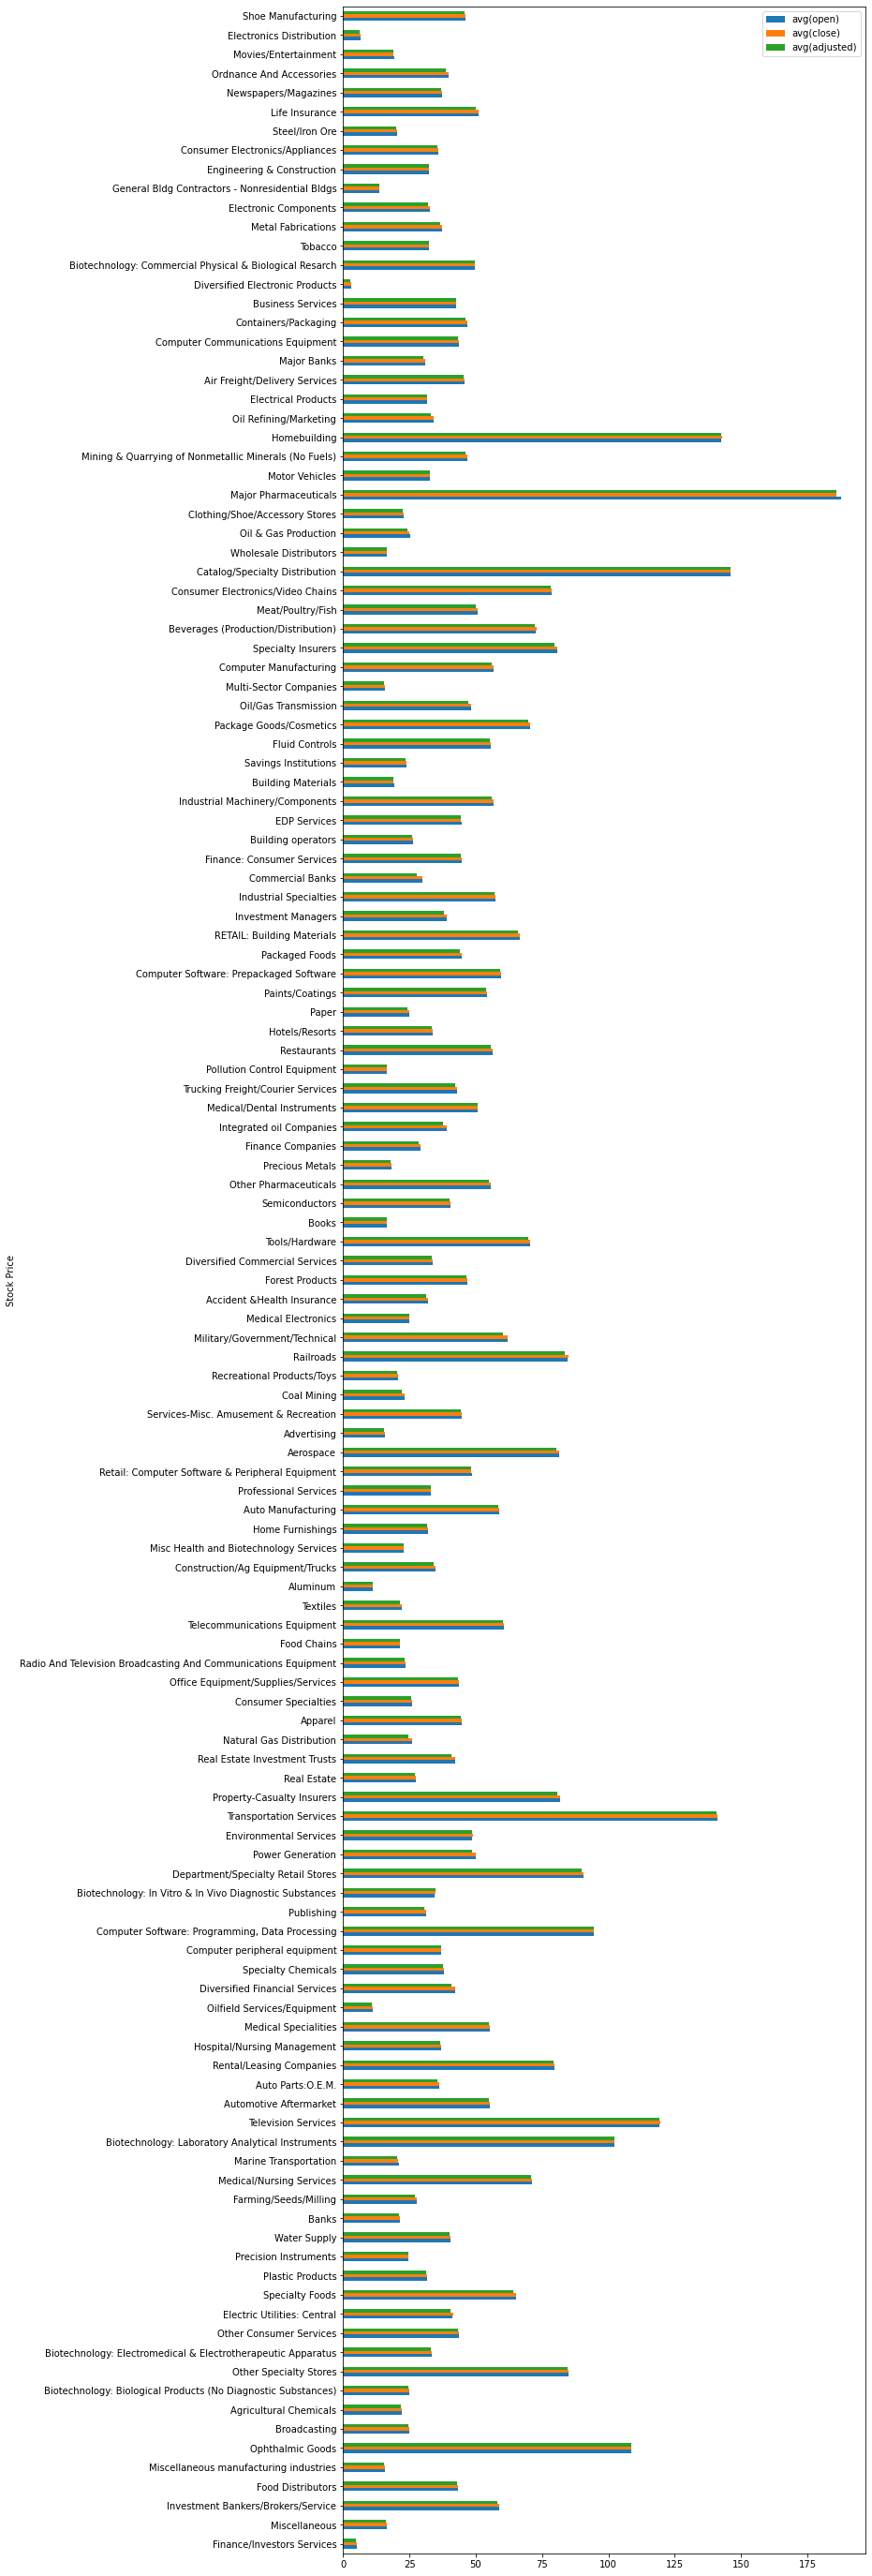

In [36]:
q  = industries_x[(industries_x.industry != 'Major Chemicals') & (industries_x.industry != 'Building Products')] #selecciona todas las industrias que no sean estas dos

q.plot(kind = 'barh', x='industry', y = q.columns.tolist()[1:], figsize=(10, 50), xlabel='Stock Price', ylabel = 'Industry')

plt.show()

In [40]:
tech = data.where(col('sector') == 'Technology').select('data', 'open', 'close', 'adjusted')
#serie temporal
tech.show()

+----------+----+-----+--------+
|      data|open|close|adjusted|
+----------+----+-----+--------+
|2019-01-02|8.51| 8.55|    8.55|
|2019-01-03| 8.5| 8.59|    8.59|
|2019-01-04|8.72| 8.88|    8.88|
|2019-01-07|8.88| 8.86|    8.86|
|2019-01-08|8.93|  9.4|     9.4|
|2019-01-09|9.46| 9.43|    9.43|
|2019-01-10|9.41|  9.4|     9.4|
|2019-01-11|9.37| 9.51|    9.51|
|2019-01-14|9.45| 9.48|    9.48|
|2019-01-15| 9.5| 9.52|    9.52|
|2019-01-16|9.53| 9.52|    9.52|
|2019-01-17|9.22|  9.5|     9.5|
|2019-01-18|9.57| 9.41|    9.41|
|2019-01-22|9.31|  8.9|     8.9|
|2019-01-23|8.93| 8.83|    8.83|
|2019-01-24|8.84| 8.73|    8.73|
|2019-01-25| 8.8| 8.93|    8.93|
|2019-01-28|8.87| 8.83|    8.83|
|2019-01-29|8.82| 8.83|    8.83|
|2019-01-30| 8.9| 8.74|    8.74|
+----------+----+-----+--------+
only showing top 20 rows



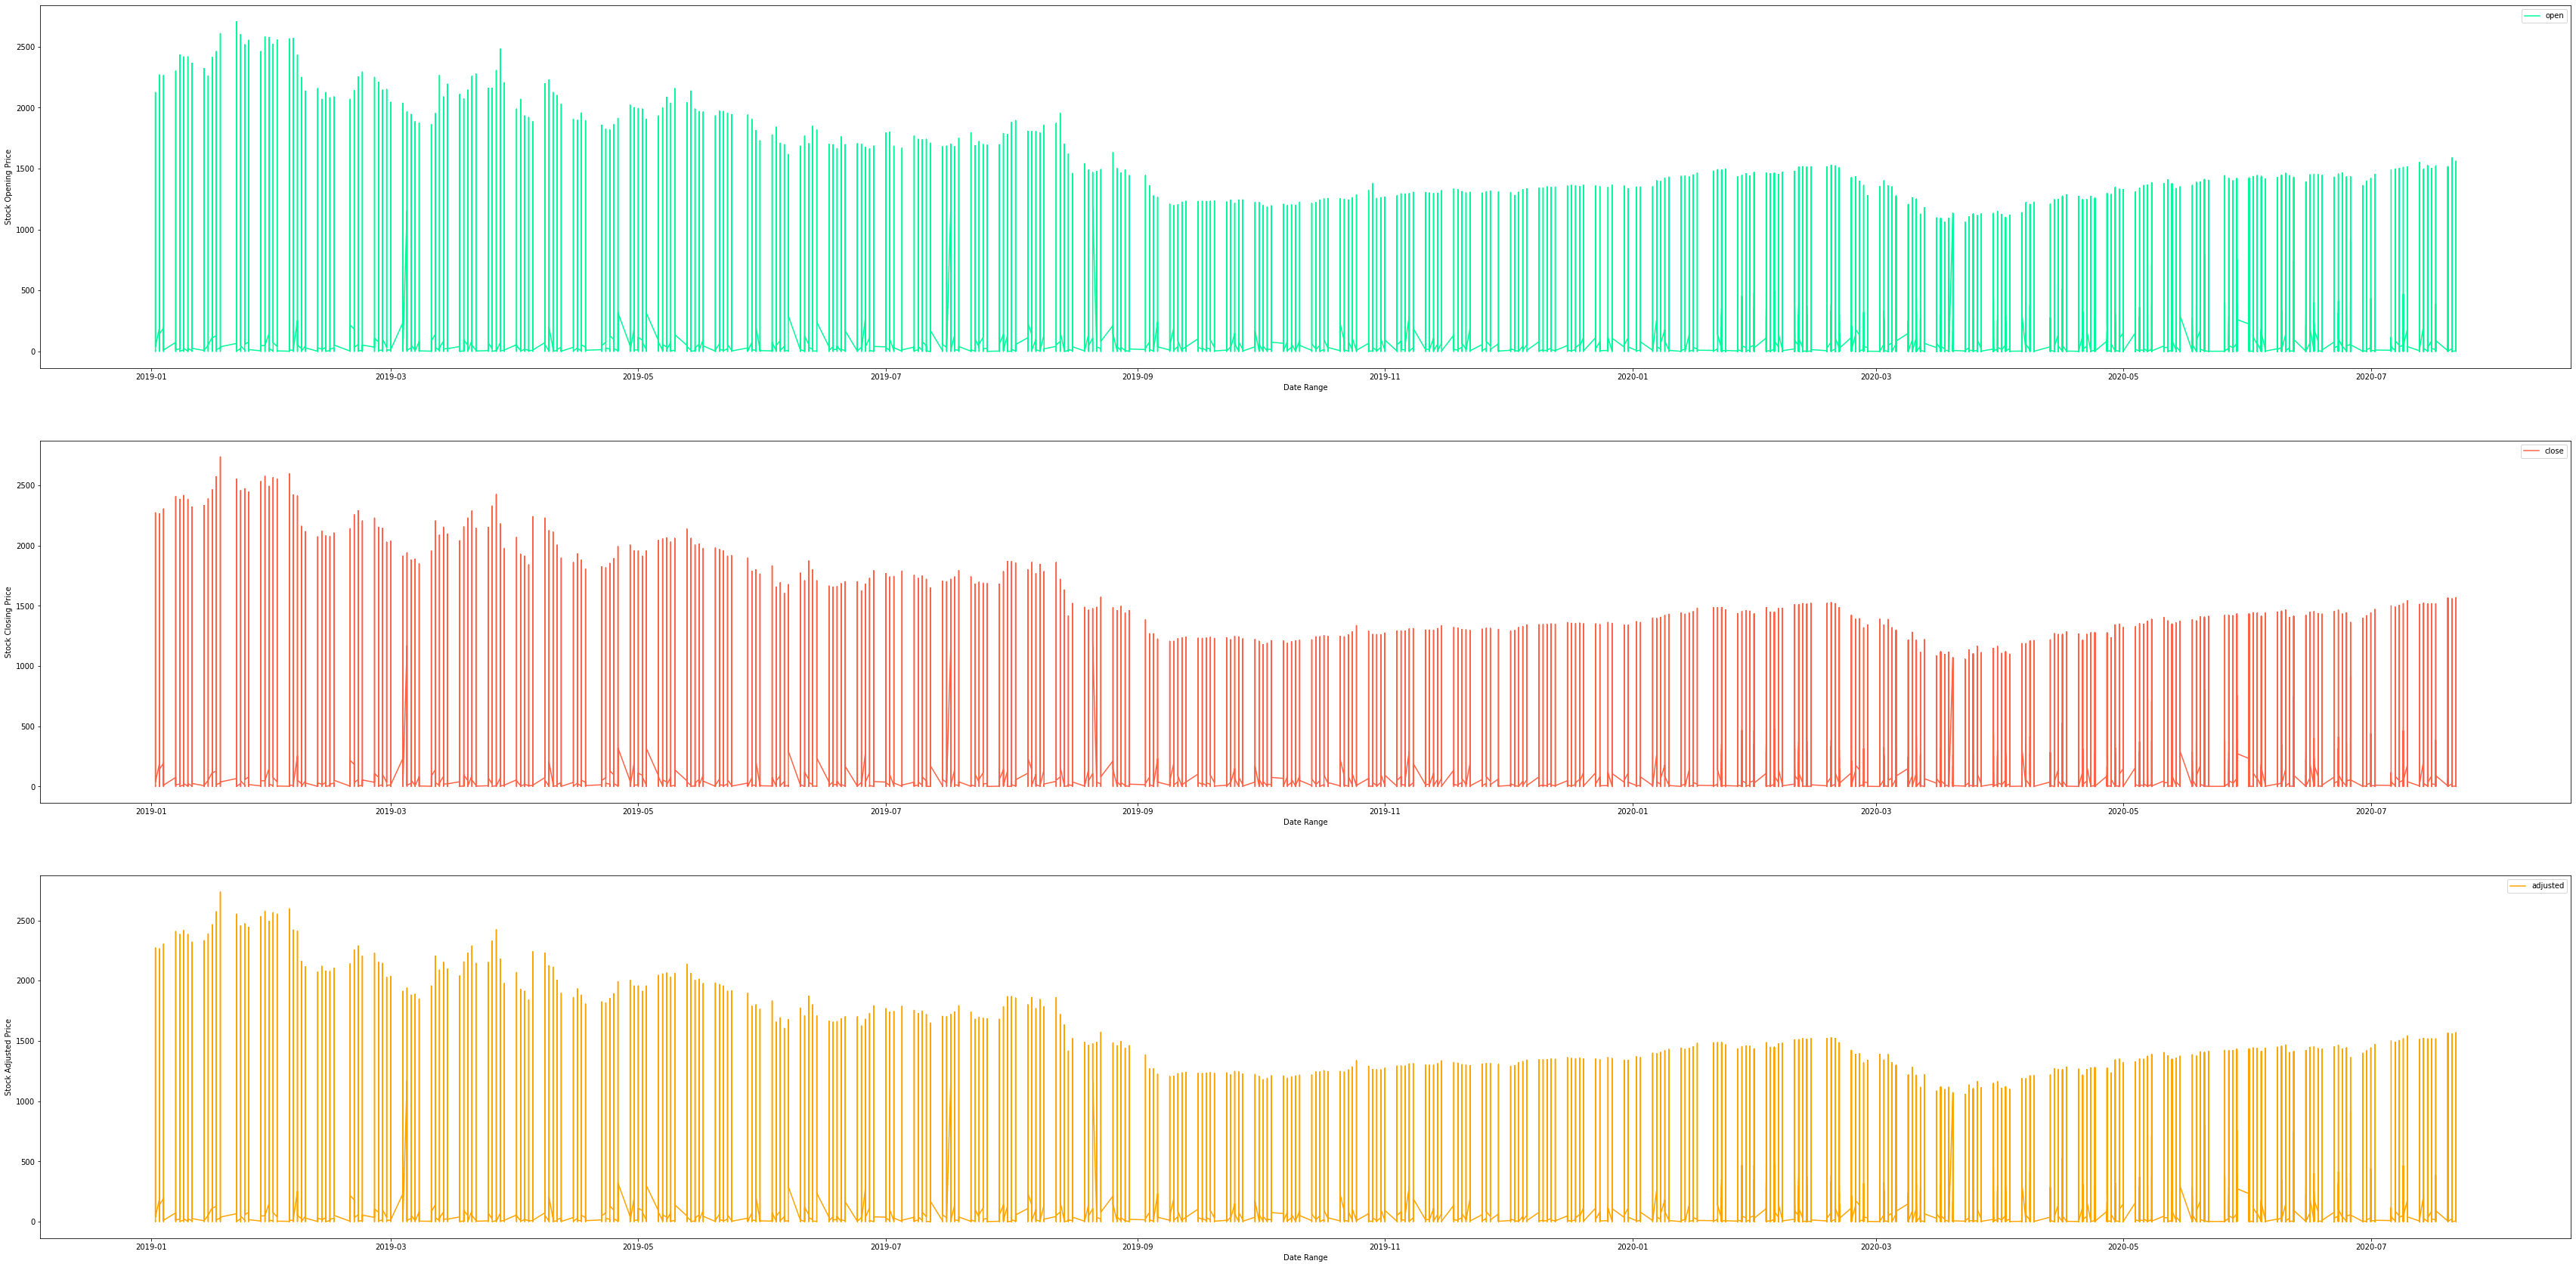

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize =(60, 30))

tech.toPandas().plot(kind = 'line', x = 'data', y='open', xlabel = 'Date Range', ylabel = 'Stock Opening Price', ax = axes[0], color = 'mediumspringgreen')

tech.toPandas().plot(kind = 'line', x = 'data', y='close', xlabel = 'Date Range', ylabel = 'Stock Closing Price', ax = axes[1], color = 'tomato')

tech.toPandas().plot(kind = 'line', x = 'data', y='adjusted', xlabel = 'Date Range', ylabel = 'Stock Adjusted Price', ax = axes[2], color = 'orange')

plt.show()

## 7. Leer y guardar de datos en archivos

In [53]:
## Writing entire data to different file formats

# CSV
data.write.csv('dataset.csv')

# JSON
data.write.save('dataset.json', format='json')

# Parquet
data.write.save('dataset.parquet', format='parquet')

## Writing selected data to different file formats

# CSV
data.select(['data', 'open', 'close', 'adjusted'])\
            .write.csv('dataset.csv')

# JSON
data.select(['data', 'open', 'close', 'adjusted'])\
    .write.save('dataset.json', format='json')

# Parquet
data.select(['data', 'open', 'close', 'adjusted'])\
    .write.save('dataset.parquet', format='parquet')

"# CSV\ndata.write.csv('dataset.csv')\n\n# JSON\ndata.write.save('dataset.json', format='json')\n\n# Parquet\ndata.write.save('dataset.parquet', format='parquet')\n\n## Writing selected data to different file formats\n\n# CSV\ndata.select(['data', 'open', 'close', 'adjusted'])            .write.csv('dataset.csv')\n\n# JSON\ndata.select(['data', 'open', 'close', 'adjusted'])    .write.save('dataset.json', format='json')\n\n# Parquet\ndata.select(['data', 'open', 'close', 'adjusted'])    .write.save('dataset.parquet', format='parquet')"